### Installation and Importing

In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompat

In [ ]:
!pip install --force-reinstall numpy scikit-image --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.6/317.6 kB 212.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 162.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 155.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 167.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 181.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 201.1 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Success

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import IntegratedGradients
from skimage.measure import label, regionprops

from sklearn.cluster import MeanShift, AgglomerativeClustering
from skimage.measure import label, regionprops

import cv2
from matplotlib import patches
from PIL import Image
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib import patches

KeyboardInterrupt: 

In [ ]:
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 23.8 MB/s eta 0:00:00


In [ ]:
model = models.resnet18(pretrained=True)
model.eval()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
image_path = "/content/ambulance.png"
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)
input_tensor.requires_grad = True

In [ ]:
output = model(input_tensor)
probabilities = torch.softmax(output, dim=1)
prediction = torch.argmax(output).item()
predicted_prob = probabilities[0, prediction].item()
print(f"Predicted Class: {prediction} with probability {predicted_prob:.4f}")

topk_probs, topk_indices = torch.topk(probabilities, k=5, dim=1)
print("Top 5 classes and probabilities:")
for i in range(5):
    print(f"Class {topk_indices[0, i].item()}: {topk_probs[0, i].item():.4f}")

In [ ]:
def compute_lrp(model, input_tensor, target_class):
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)
    relevance = input_tensor.grad.clone().detach()
    relevance = relevance.abs().sum(dim=1)[0]
    return relevance


In [ ]:
lrp_map = compute_lrp(model, input_tensor, prediction).cpu().numpy()
lrp_map = (lrp_map - lrp_map.min()) / (lrp_map.max() - lrp_map.min() + 1e-8)

In [ ]:
ig = IntegratedGradients(model)
baseline = torch.zeros_like(input_tensor)
attributions, _ = ig.attribute(input_tensor, baseline, target=prediction, return_convergence_delta=True)

ig_map = attributions.squeeze().detach().numpy()
ig_map = np.transpose(ig_map, (1, 2, 0))
ig_map = np.mean(ig_map, axis=2)
ig_map = np.maximum(ig_map, 0)
ig_map /= ig_map.max() + 1e-8

In [ ]:
def threshold_map(saliency_map, percentile=80):
    threshold = np.percentile(saliency_map, percentile)
    return (saliency_map >= threshold).astype(np.uint8)

In [ ]:
lrp_thresh = threshold_map(lrp_map, percentile=95)
ig_thresh = threshold_map(ig_map, percentile=95)

intersection = (lrp_thresh & ig_thresh).astype(np.uint8)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(lrp_map, cmap='gray')
plt.title("LRP Heatmap")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(ig_map, cmap='gray')
plt.title("IG Heatmap")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(intersection, cmap='gray')
plt.title("Common Pixels (IG ∩ LRP)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow((lrp_thresh + ig_thresh), cmap='gray')
plt.title("Overlay of LRP + IG Thresholds")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def cluster_agglomerative(binary_map, n_clusters=10, linkage='ward'):
    coords = np.argwhere(binary_map == 1)
    if coords.shape[0] == 0:
        return np.zeros_like(binary_map, dtype=int)

    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    agg.fit(coords)

    labels = agg.labels_
    labeled_map = np.full(binary_map.shape, -1, dtype=int)
    for i, coord in enumerate(coords):
        labeled_map[coord[0], coord[1]] = labels[i]

    return labeled_map

In [ ]:
# Example usage
agg_labels = cluster_agglomerative(intersection, n_clusters=10, linkage='ward')

# Mask out background (-1) and set its color
masked_labels = np.ma.masked_where(agg_labels == -1, agg_labels)

# Custom colormap for 10 clusters
cmap = plt.get_cmap('tab10', 10)
cmap.set_bad(color='white')  # Change this to any background color you want

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(masked_labels, cmap=cmap)
ax.set_title("Agglomerative Clustering (10 clusters)")
ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def unnormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()
    for i in range(img_tensor.shape[0]):
        img_tensor[i] = img_tensor[i] * std[i] + mean[i]
    return img_tensor

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformed_img = unnormalize(input_tensor[0], mean, std)
transformed_img_np = transformed_img.detach().cpu().numpy().transpose(1, 2, 0)
transformed_img_np = np.clip(transformed_img_np, 0, 1)

In [ ]:
def draw_cluster_boundaries(image_np, labeled_map, title="Cluster Boundaries", skip_noise=True):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    clusters = np.unique(labeled_map)
    for cl in clusters:
        if skip_noise and cl == -1:
            continue
        coords = np.argwhere(labeled_map == cl)
        if coords.size == 0:
            continue
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        width = max_col - min_col
        height = max_row - min_row

        rect = patches.Rectangle((min_col, min_row), width, height, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(min_col, min_row, f"{cl}", color='yellow', fontsize=12, weight='bold')

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

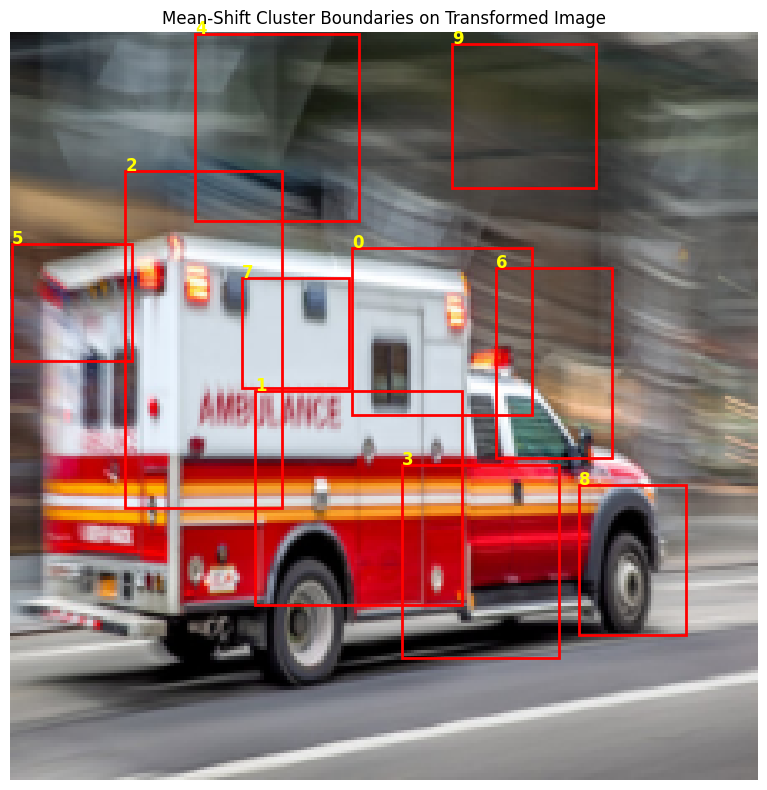

In [ ]:
draw_cluster_boundaries(transformed_img_np, agg_labels, title="Mean-Shift Cluster Boundaries on Transformed Image")


In [ ]:
def zero_bbox(image_np, bbox):
    modified_image = image_np.copy()
    modified_image[bbox[0]:bbox[2], bbox[1]:bbox[3], :] = 0
    return modified_image

In [ ]:
print(f"Baseline Prediction: Class {prediction} with probability {predicted_prob:.4f}")


Baseline Prediction: Class 407 with probability 0.7276


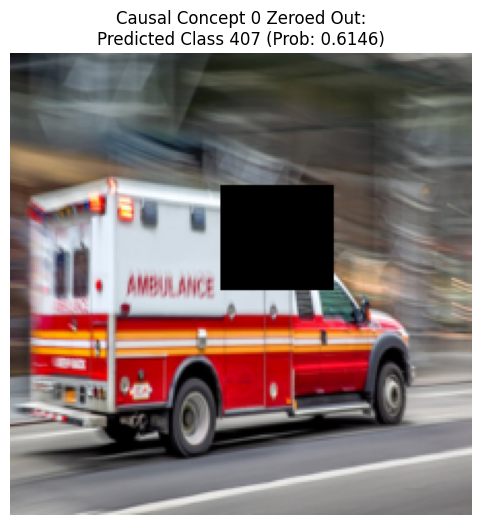

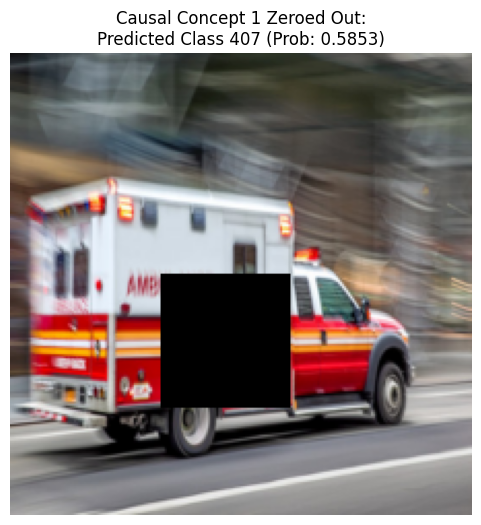

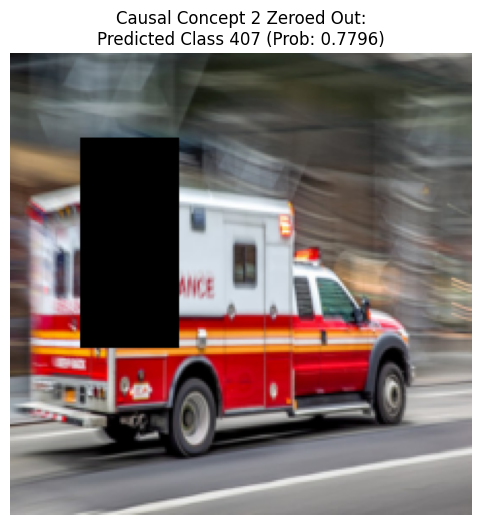

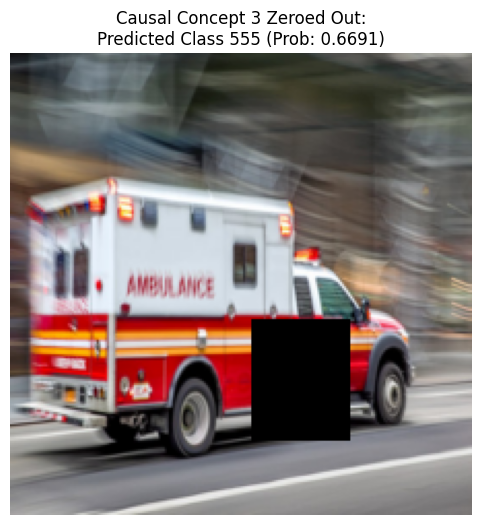

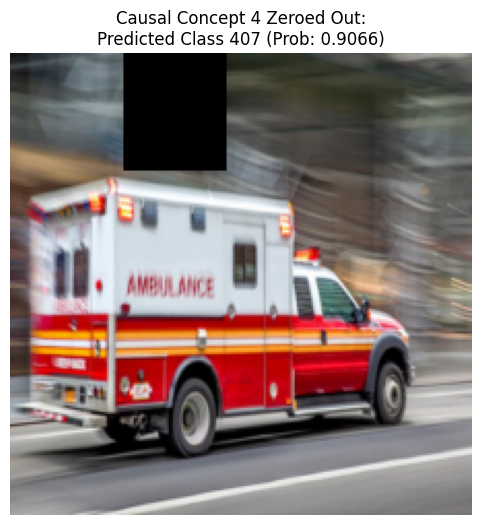

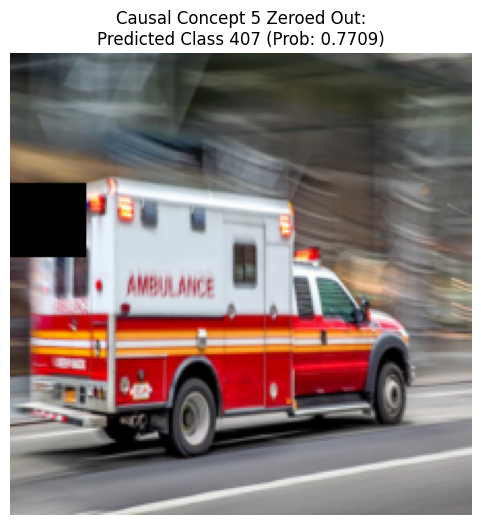

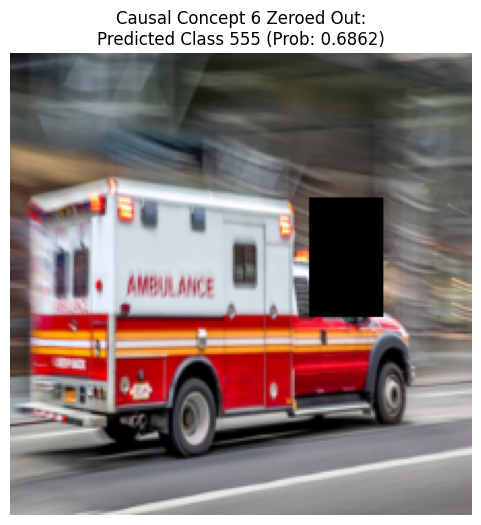

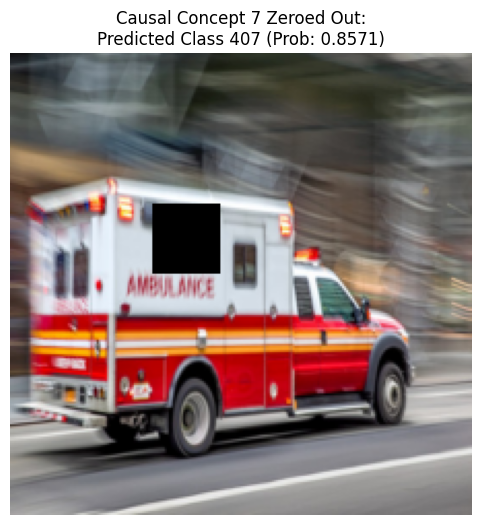

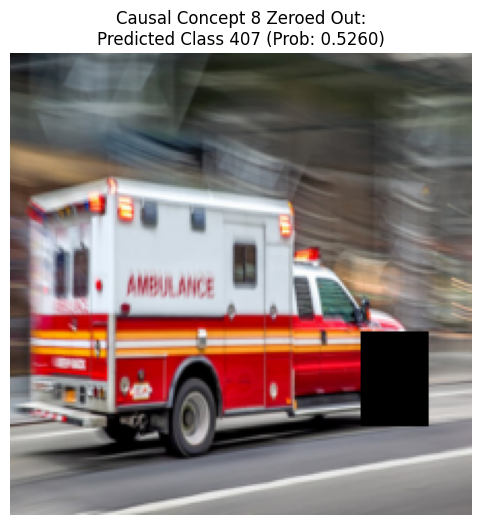

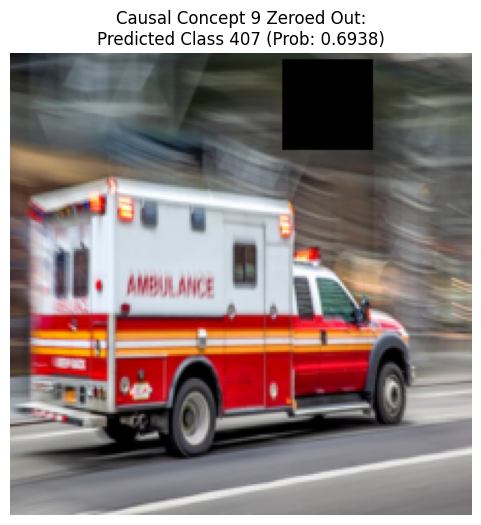


Comparison with Baseline:
Causal Concept 0: Modified Prediction - Class 407 (Probability: 0.6146) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 1: Modified Prediction - Class 407 (Probability: 0.5853) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 2: Modified Prediction - Class 407 (Probability: 0.7796) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 3: Modified Prediction - Class 555 (Probability: 0.6691) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 4: Modified Prediction - Class 407 (Probability: 0.9066) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 5: Modified Prediction - Class 407 (Probability: 0.7709) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 6: Modified Prediction - Class 555 (Probability: 0.6862) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 7: Modified Prediction - Class 407 (Probability: 0.8571) vs Baseline Class 407 (Probability: 0.7276)
Causal Concept 8: Modified Prediction - Class

In [ ]:
unique_clusters = np.unique(agg_labels)
results = []

for cl in unique_clusters:
    if cl == -1:
        continue

    coords = np.argwhere(agg_labels == cl)
    min_row, min_col = coords.min(axis=0)
    max_row, max_col = coords.max(axis=0)
    bbox = (min_row, min_col, max_row + 1, max_col + 1)

    modified_np = zero_bbox(original_np, bbox)
    modified_img = Image.fromarray(modified_np)

    input_tensor_modified = transform(modified_img).unsqueeze(0)
    input_tensor_modified.requires_grad = True

    output_modified = model(input_tensor_modified)
    probabilities_modified = torch.softmax(output_modified, dim=1)
    prediction_modified = torch.argmax(output_modified).item()
    predicted_prob_modified = probabilities_modified[0, prediction_modified].item()

    results.append((cl, prediction_modified, predicted_prob_modified))

    plt.figure(figsize=(6, 6))
    plt.imshow(modified_np)
    plt.title(f"Causal Concept {cl} Zeroed Out:\nPredicted Class {prediction_modified} (Prob: {predicted_prob_modified:.4f})")
    plt.axis("off")
    plt.show()

print("\nComparison with Baseline:")
for cl, pred, prob in results:
    print(f"Causal Concept {cl}: Modified Prediction - Class {pred} (Probability: {prob:.4f}) vs Baseline Class {prediction} (Probability: {predicted_prob:.4f})")



In [ ]:
def compute_pcs_and_bf(p_orig, p_mod, epsilon=1e-6):
    p_orig = np.clip(p_orig, epsilon, 1 - epsilon)
    p_mod = np.clip(p_mod, epsilon, 1 - epsilon)

    pcs = (p_orig - p_mod) / p_orig

    bf = (p_orig / (1 - p_orig)) / (p_mod / (1 - p_mod))

    return pcs, bf

In [ ]:
def plot_concept_summary(
    input_tensor, agg_labels, model, transform,
    prediction, predicted_prob
):
    """
    Plots the per-cluster probability drop after zeroing out bounding boxes.
    Uses the same cluster-label map as single_concept_ablation().
    """

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    original_np = unnormalize_and_to_np(input_tensor[0], mean, std)

    baseline_class = prediction
    baseline_prob = predicted_prob

    clusters = [cl for cl in np.unique(agg_labels) if cl != -1]
    effects = []
    concept_labels = []

    def get_bbox_for_cluster(cluster_label, label_map):
        coords = np.argwhere(label_map == cluster_label)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        return (min_row, min_col, max_row + 1, max_col + 1)

    for cl in clusters:
        bbox = get_bbox_for_cluster(cl, agg_labels)
        modified_np = zero_bbox(original_np, bbox)
        modified_img = Image.fromarray(modified_np)
        input_mod = transform(modified_img).unsqueeze(0)
        input_mod.requires_grad = True

        output_mod = model(input_mod)
        probs_mod = torch.softmax(output_mod, dim=1)
        mod_prob = probs_mod[0, baseline_class].item()

        diff = mod_prob - baseline_prob
        effects.append(diff)
        concept_labels.append(cl)

    # Plot the summary
    colors = ['green' if diff < 0 else 'red' for diff in effects]

    plt.figure(figsize=(10, 6))
    bars = plt.bar([str(c) for c in concept_labels], effects, color=colors)
    plt.xlabel("Causal Concept")
    plt.ylabel("Change in Baseline Class Probability\n(Modified - Baseline)")
    plt.title("Effect of Removing Each Causal Concept on Model Prediction")
    plt.axhline(0, color='black', linewidth=0.8)

    for bar, diff in zip(bars, effects):
        height = bar.get_height()
        plt.annotate(f"{diff:.3f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.show()

    # Print summary
    print("Summary of Causal Concept Effects (per concept):")
    for cl, diff in zip(concept_labels, effects):
        effect_type = "Positive Contribution" if diff < 0 else "Negative Effect"
        print(f"Concept {cl}: Change = {diff:.4f} → {effect_type}")

In [ ]:
plot_concept_summary(
    input_tensor=input_tensor,
    agg_labels=agg_labels,
    model=model,
    transform=transform,
    prediction=prediction,
    predicted_prob=predicted_prob
)


In [ ]:
def plot_pcs_visualization(
    input_tensor,
    agg_labels,
    model,
    transform,
    prediction,
    predicted_prob,
    compute_pcs_and_bf  # a function that returns (pcs, bf)
):
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    original_np = unnormalize_and_to_np(input_tensor[0], mean, std)

    def get_bbox(cluster_label):
        coords = np.argwhere(agg_labels == cluster_label)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        return (min_row, min_col, max_row + 1, max_col + 1)

    detailed_results = []

    clusters = [cl for cl in np.unique(agg_labels) if cl != -1]

    for cl in clusters:
        bbox = get_bbox(cl)

        modified_np = zero_bbox(original_np, bbox)
        modified_img = Image.fromarray(modified_np)
        input_mod = transform(modified_img).unsqueeze(0)
        input_mod.requires_grad = True

        output = model(input_mod)
        probs = torch.softmax(output, dim=1)
        mod_prob = probs[0, prediction].item()
        mod_pred = torch.argmax(probs).item()

        pcs, bf = compute_pcs_and_bf(predicted_prob, mod_prob)

        detailed_results.append({
            'cluster': cl,
            'modified_pred': mod_pred,
            'modified_prob': mod_prob,
            'pcs': pcs,
            'bf': bf,
            'bbox': bbox
        })

    # Sort by PCS descending
    detailed_results.sort(key=lambda x: x['pcs'], reverse=True)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_np)
    ax.axis("off")

    cmap = cm.get_cmap("Reds")
    norm = Normalize(vmin=0, vmax=max(r['pcs'] for r in detailed_results))

    for res in detailed_results:
        cl = res['cluster']
        pcs = res['pcs']
        bf = res['bf']
        bbox = res['bbox']
        color = cmap(norm(pcs))

        rect = Rectangle(
            (bbox[1], bbox[0]),
            bbox[3] - bbox[1],
            bbox[2] - bbox[0],
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            bbox[1], bbox[0] - 5,
            f"#{cl} | PCS: {pcs:.2f} | BF: {bf:.1f}",
            color='black', fontsize=9,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

    plt.show()


In [ ]:
plot_pcs_visualization(
    input_tensor=input_tensor,
    agg_labels=agg_labels,
    model=model,
    transform=transform,
    prediction=prediction,
    predicted_prob=predicted_prob,
    compute_pcs_and_bf=compute_pcs_and_bf
)
